# Exploratory Data Analysis

### Cleaning the Dataset

In [8]:
import pandas as pd
import re

df = pd.read_csv('response_times_original_2009-2014.csv', low_memory=False)

# Function to detect scientific notation patterns
def contains_scientific_notation(value):
    if isinstance(value, str) and re.match(r'^\d+(\.\d+)?[eE][+-]?\d+$', value):
        return True
    return False

# Function to detect 'redacted' in any format
def contains_redacted(value):
    if isinstance(value, str) and 'redacted' in value.lower():
        return True
    return False

# Remove rows where any column contains scientific notation or 'redacted'
df_cleaned = df[~df.apply(lambda row: row.astype(str).apply(lambda x: contains_scientific_notation(x) or contains_redacted(x)).any(), axis=1)]

# Remove rows where the Event_Cancelled column contains 'Y'
df_cleaned = df_cleaned[df_cleaned['Event_Cancelled'] != 'Y']

# Remove rows where the Resp_Time column is empty
df_cleaned = df_cleaned[df_cleaned['Resp_Time'].notna()]

# Save the cleaned dataset to a new CSV file
df_cleaned.to_csv('response_times_original_2009-2014_cleaned.csv', index=False)

print(f"Original dataset size: {df.shape[0]}")
print(f"Cleaned dataset size: {df_cleaned.shape[0]}")


Original dataset size: 2411093
Cleaned dataset size: 1083572


### Merging the MPDS Codes Description, First Responders, Qualifications, and Response Mode

In [46]:
import pandas as pd

df_cleaned = pd.read_csv('response_times_original_2009-2014_cleaned.csv')

# Load the MPDS Codes and RAP Changes data, specifying the engine
mpds_codes = pd.read_excel('MPDS_Codes_and_RAP_Changes.xlsx', engine='openpyxl')

# Convert 'MPDS_Code' column to lowercase in both datasets
df_cleaned['MPDS_Code_Initial'] = df_cleaned['MPDS_Code_Initial'].str.lower()
mpds_codes['MPDS_Code'] = mpds_codes['MPDS_Code'].str.lower()

# Select the relevant columns from MPDS Codes and RAP Changes data
mpds_codes = mpds_codes[['MPDS_Code', 'Description', 'First_Responders', 'Qualification', 'Response_Mode']]

# Merge the cleaned dataset with the MPDS codes
df_merged = pd.merge(df_cleaned, mpds_codes, left_on='MPDS_Code_Initial', right_on='MPDS_Code', how='left')

# Drop the MPDS_Code column from the merge (since it's redundant now)
df_merged = df_merged.drop(columns=['MPDS_Code'])

# New column names with "initial" added
new_columns = ['Description', 'First_Responders', 'Qualification', 'Response_Mode']
new_columns_with_initial = [f"{col}_initial" for col in new_columns]

# Insert the new columns after the MPDS_Code_Initial column
for i, (column, column_with_initial) in enumerate(zip(new_columns, new_columns_with_initial), start=1):
    df_merged.insert(df_merged.columns.get_loc('MPDS_Code_Initial') + i, column_with_initial, df_merged.pop(column))

# Save the merged dataset to a new CSV file
df_merged.to_csv('response_times_original_2009-2014_merged_Initial.csv', index=False)

print(f"Cleaned dataset size: {df_cleaned.shape[0]}")
print(f"Merged dataset size: {df_merged.shape[0]}")


/var/folders/vl/xzh_hz6x4w561b9bv8p5w8wm0000gn/T/ipykernel_9982/2222992389.py:4: DtypeWarning: Columns (3,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df_cleaned = pd.read_csv('response_times_original_2009-2014_cleaned.csv')


Cleaned dataset size: 1083572
Merged dataset size: 1083572


In [47]:
import pandas as pd

df_cleaned = pd.read_csv('response_times_original_2009-2014_merged_Initial.csv')

# Load the MPDS Codes and RAP Changes data, specifying the engine
mpds_codes = pd.read_excel('MPDS_Codes_and_RAP_Changes.xlsx', engine='openpyxl')

# Convert 'MPDS_Code' column to lowercase in both datasets
df_cleaned['MPDS_Code_Final'] = df_cleaned['MPDS_Code_Final'].str.lower()
mpds_codes['MPDS_Code'] = mpds_codes['MPDS_Code'].str.lower()

# Select the relevant columns from MPDS Codes and RAP Changes data
mpds_codes = mpds_codes[['MPDS_Code', 'Description', 'First_Responders', 'Qualification', 'Response_Mode']]

# Merge the cleaned dataset with the MPDS codes
df_merged = pd.merge(df_cleaned, mpds_codes, left_on='MPDS_Code_Final', right_on='MPDS_Code', how='left')

# Drop the MPDS_Code column from the merge (since it's redundant now)
df_merged = df_merged.drop(columns=['MPDS_Code'])

# New column names with "initial" added
new_columns = ['Description', 'First_Responders', 'Qualification', 'Response_Mode']
new_columns_with_initial = [f"{col}_final" for col in new_columns]

# Insert the new columns after the MPDS_Code_Final column
for i, (column, column_with_initial) in enumerate(zip(new_columns, new_columns_with_initial), start=1):
    df_merged.insert(df_merged.columns.get_loc('MPDS_Code_Final') + i, column_with_initial, df_merged.pop(column))

# Save the merged dataset to a new CSV file
df_merged.to_csv('response_times_original_2009-2014_merged.csv', index=False)

print(f"Cleaned dataset size: {df_cleaned.shape[0]}")
print(f"Merged dataset size: {df_merged.shape[0]}")


/var/folders/vl/xzh_hz6x4w561b9bv8p5w8wm0000gn/T/ipykernel_9982/1665534498.py:4: DtypeWarning: Columns (3,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df_cleaned = pd.read_csv('response_times_original_2009-2014_merged_Initial.csv')


Cleaned dataset size: 1083572
Merged dataset size: 1083572


### Adding the response mode code descriptions to the dataset

In [57]:
import pandas as pd

df_merged = pd.read_csv('response_times_original_2009-2014_merged.csv')

# Define the mapping of response modes to their corresponding descriptions
response_mode_mapping = {
    1: 'non life threatening or deferrable',
    2: 'scheduled transfer or appointment',
    3: 'emergent (may use lights or sirens)',
    4: 'life threatening (must use lights or sirens)'
}

# Function to map response modes to their descriptions
def map_response_mode(mode):
    return response_mode_mapping.get(mode)

# Add new columns for Response Mode descriptions
new_columns = ['Response_Mode_Initial_Description', 'Response_Mode_Final_Description']
new_column_values = [df_merged['Response_Mode_Initial'].map(map_response_mode),
                     df_merged['Response_Mode_Final'].map(map_response_mode)]

# Insert new columns after columns D and K
df_merged.insert(4, new_columns[0], new_column_values[0])
df_merged.insert(12, new_columns[1], new_column_values[1])

# Save the updated dataset to a new CSV file
df_merged.to_csv('response_times_original_2009-2014_cleaned_merged_final.csv', index=False)



print(f"Merged dataset size: {df_merged.shape[0]}")


/var/folders/vl/xzh_hz6x4w561b9bv8p5w8wm0000gn/T/ipykernel_9982/1252974856.py:4: DtypeWarning: Columns (3,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df_merged = pd.read_csv('response_times_original_2009-2014_merged.csv')


Merged dataset size: 1083572


### Global Vars

In [92]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define the data types for the problematic columns
dtype_spec = {
    'Call_Year': 'int64',
    'Community_Type': 'str',
    'Call_Loc_Community': 'str',
    'Response_Mode_Initial': 'str',
    'Response_Mode_Initial_Description': 'str',
    'MPDS_Code_Initial': 'str',
    'Description_initial': 'str',
    'First_Responders_initial': 'str',
    'Qualification_initial': 'str',
    'Response_Mode_initial': 'str',
    'Det_Code_Init': 'str',
    'Response_Mode_Final': 'str',
    'Response_Mode_Final_Description': 'str',
    'MPDS_Code_Final': 'str',
    'Description_final': 'str',
    'First_Responders_final': 'str',
    'Qualification_final': 'str',
    'Response_Mode_final': 'str',
    'Det_Code_Final': 'str',
    'Event_Cancelled': 'str',
    'Resp_Time': 'float64',
    'To_Hosp': 'float64'

}

df = pd.read_csv('response_times_original_2009-2014_cleaned_merged_final.csv', dtype=dtype_spec, low_memory=False)


### Average Response Time by Call Location

In [93]:

# Group by Call_Loc_Community and Community_Type, then calculate the average response time
grouped_df = df.groupby(['Call_Loc_Community', 'Community_Type'])['Resp_Time'].mean().reset_index()

# Rename columns for clarity
grouped_df.columns = ['Call_Loc_Community', 'Community_Type', 'Average_Response_Time']

# Sort the dataframe by Average_Response_Time in descending order
grouped_df = grouped_df.sort_values(by='Average_Response_Time', ascending=False)

styled_table = (grouped_df.style
                .background_gradient(cmap='coolwarm', subset=['Average_Response_Time'])
                .applymap(color_negative_red, subset=['Average_Response_Time'])
                .set_caption('Average Response Time by Call Location')
                .set_table_styles([{
                    'selector': 'caption',
                    'props': 'caption-side: top; font-size: 1.5em; color: white;'
                }]))

styled_table


,Call_Loc_Community,Community_Type,Average_Response_Time
4,Langley,Metro,17.413019
0,Burnaby,Metro,17.404208
6,Richmond,Metro,16.560391
8,Surrey,Metro,16.554780
1,Chilliwack,Urban,14.124459
9,Vancouver,Metro,13.921953
2,Kamloops,Urban,13.061942
3,Kelowna,Urban,11.873961
7,Saanich,Metro,11.296408
5,Nanaimo,Urban,10.771496


### Total Calls in Each City

In [25]:
# Calculate the total number of calls in each city
total_calls = df.groupby(['Call_Loc_Community', 'Community_Type']).size().reset_index(name='Total_Calls')

# Sort the DataFrame by Total_Calls in descending order
total_calls = total_calls.sort_values(by='Total_Calls', ascending=False)

# Style the table using pandas Styler
styled_table = (total_calls.style
                .set_caption('Total Calls in Each City')
                .set_table_styles([{
                    'selector': 'caption',
                    'props': 'caption-side: top; font-size: 1.5em; color: white;'
                }]))

styled_table

,Call_Loc_Community,Community_Type,Total_Calls
9,Vancouver,Metro,360969
8,Surrey,Metro,194379
0,Burnaby,Metro,89741
3,Kelowna,Urban,64849
10,Victoria,Metro,64345
6,Richmond,Metro,64258
4,Langley,Metro,59515
1,Chilliwack,Urban,50006
5,Nanaimo,Urban,49217
2,Kamloops,Urban,46900


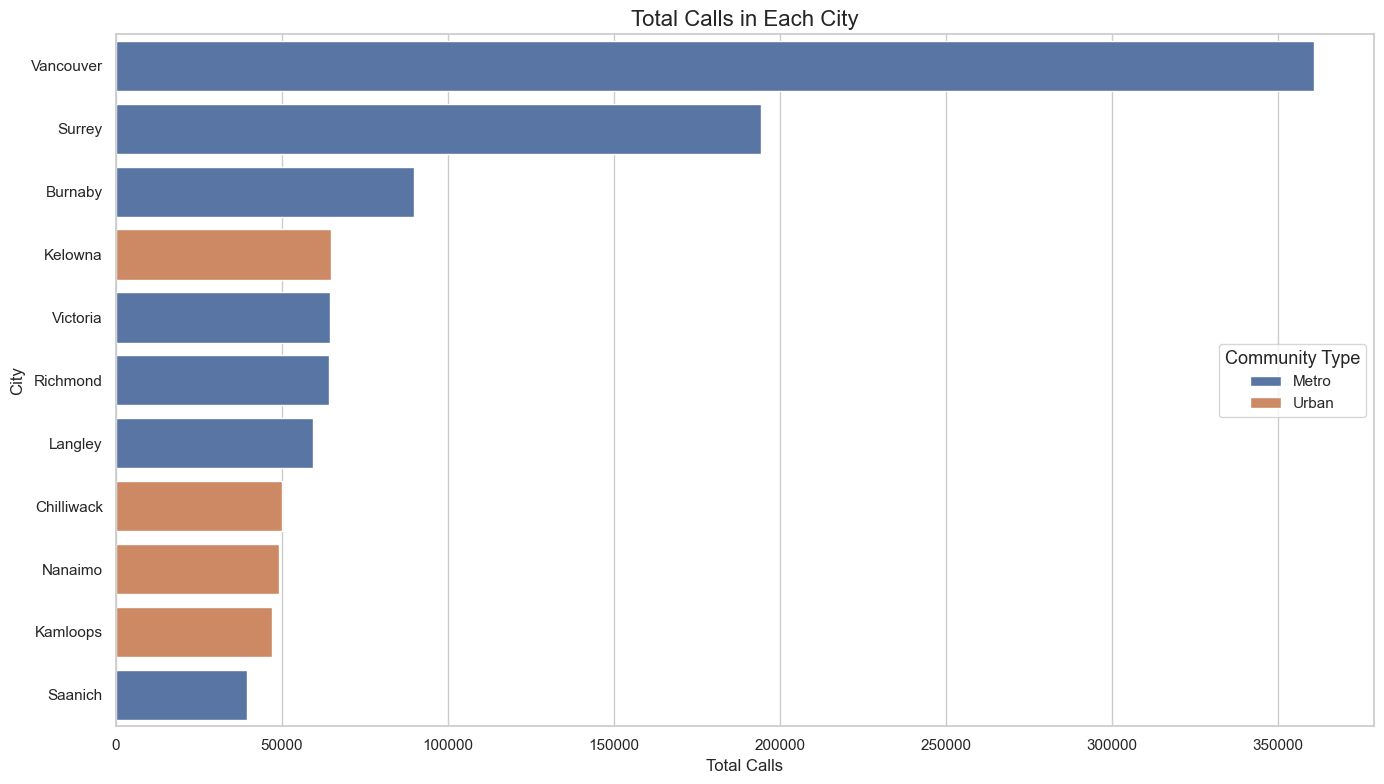

In [27]:
# Calculate the total number of calls in each city
total_calls = df.groupby(['Call_Loc_Community', 'Community_Type']).size().reset_index(name='Total_Calls')

# Sort the DataFrame by Total_Calls in descending order
total_calls = total_calls.sort_values(by='Total_Calls', ascending=False)

# Set up the matplotlib figure and axes
plt.figure(figsize=(14, 8))

# Create a bar plot using Seaborn
bar_plot = sns.barplot(
    x='Total_Calls', 
    y='Call_Loc_Community', 
    data=total_calls, 
    hue='Community_Type', 
    dodge=False
)

# Add title and labels
bar_plot.set_title('Total Calls in Each City', fontsize=16)
bar_plot.set_xlabel('Total Calls', fontsize=12)
bar_plot.set_ylabel('City', fontsize=12)

# Customize the legend
plt.legend(title='Community Type', title_fontsize='13', fontsize='11')

# Adjust layout for better display
plt.tight_layout()

plt.show()

### Average Response Time by Community Type

In [30]:
# Calculate the average response time for Metro and Urban areas
avg_response_times = df.groupby('Community_Type')['Resp_Time'].mean().reset_index()
avg_response_times.columns = ['Community_Type', 'Average_Response_Time']

# Set up the plot style
sns.set(style="whitegrid")

# Create the table using Pandas Styler
styled_table = (avg_response_times.style
                .set_caption('Average Response Time by Community Type')
                .set_table_styles([{
                    'selector': 'caption',
                    'props': 'caption-side: top; font-size: 1.5em; color: white;'
                }, {
                    'selector': 'th',
                    'props': 'font-size: 1.1em; text-align: center;'
                }, {
                    'selector': 'td',
                    'props': 'font-size: 1.1em; text-align: center;'
                }]))

styled_table

,Community_Type,Average_Response_Time
0,Metro,14.927481
1,Urban,12.414292


### Total Calls and Average Response Time by L&S vs No L&S

In [50]:
# Calculate count and average response time for each 'Response_Mode_initial'
response_mode_stats = df.groupby('Response_Mode_initial')['Resp_Time'].agg(['count', 'mean']).reset_index()
response_mode_stats.columns = ['Response_Mode_initial', 'Total_Calls', 'Average_Response_Time']

# Display the table using pandas Styler
styled_table = (response_mode_stats.style
                .set_caption('Total Calls and Average Response Time by L&S vs No L&S')
                .set_table_styles([{
                    'selector': 'caption',
                    'props': 'caption-side: top; font-size: 1.5em; color: White;'
                }])
                .format({
                    'Total_Calls': '{:,.0f}',
                    'Average_Response_Time': '{:.2f}'
                }))

styled_table

,Response_Mode_initial,Total_Calls,Average_Response_Time
0,L&S,"482,987",10.39
1,No L&S,"579,679",17.90


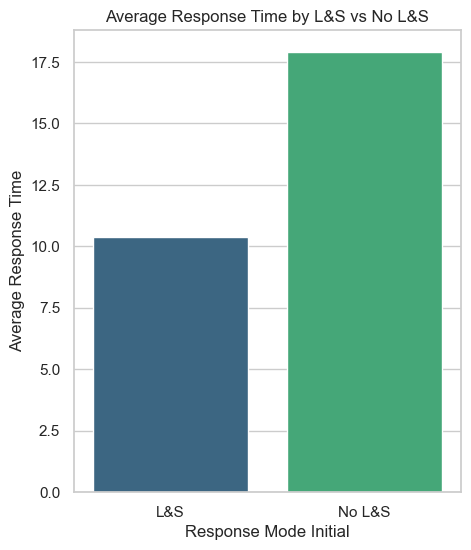

In [58]:
plt.figure(figsize=(5, 6))
sns.barplot(x='Response_Mode_initial', y='Average_Response_Time', data=response_mode_stats, palette='viridis')
plt.title('Average Response Time by L&S vs No L&S')
plt.xlabel('Response Mode Initial')
plt.ylabel('Average Response Time')
plt.show()

### Total Calls and Average Response Time by Response Mode Initial

In [44]:
# Group by 'Response_Mode_initial' and 'Response_Mode_Initial_Description'
response_mode_desc_stats = df.groupby(['Response_Mode_Initial', 'Response_Mode_Initial_Description'])['Resp_Time'].agg(['count', 'mean']).reset_index()
response_mode_desc_stats.columns = ['Response_Mode_Initial', 'Response_Mode_Initial_Description', 'Total_Calls', 'Average_Response_Time']

# Display the table using pandas Styler
styled_table = (response_mode_desc_stats.style
                .set_caption('Total Calls and Average Response Time by Response Mode Initial')
                .set_table_styles([{
                    'selector': 'caption',
                    'props': 'caption-side: top; font-size: 1.5em; color: White;'
                }])
                .format({
                    'Total_Calls': '{:,.0f}',
                    'Average_Response_Time': '{:.2f}'
                }))

styled_table

,Response_Mode_Initial,Response_Mode_Initial_Description,Total_Calls,Average_Response_Time
0,1,non life threatening or deferrable,"239,882",20.28
1,2,scheduled transfer or appointment,"235,720",18.59
2,3,emergent (may use lights or sirens),"572,974",10.23


### Total Calls and Average Response Time by Response Mode Initial and L&S

In [46]:
# Group by 'Response_Mode_initial' and 'Response_Mode_Initial_Description'
response_mode_desc_stats = df.groupby(['Response_Mode_Initial', 'Response_Mode_Initial_Description', 'Response_Mode_initial'])['Resp_Time'].agg(['count', 'mean']).reset_index()
response_mode_desc_stats.columns = ['Response_Mode_Initial', 'Response_Mode_Initial_Description', 'Response_Mode_initial', 'Total_Calls', 'Average_Response_Time']

# Display the table using pandas Styler
styled_table = (response_mode_desc_stats.style
                .set_caption('Total Calls and Average Response Time by Response Mode Initial and L&S')
                .set_table_styles([{
                    'selector': 'caption',
                    'props': 'caption-side: top; font-size: 1.5em; color: White;'
                }])
                .format({
                    'Total_Calls': '{:,.0f}',
                    'Average_Response_Time': '{:.2f}'
                }))

styled_table

,Response_Mode_Initial,Response_Mode_Initial_Description,Response_Mode_initial,Total_Calls,Average_Response_Time
0,1,non life threatening or deferrable,No L&S,"239,882",20.28
1,2,scheduled transfer or appointment,L&S,"22,531",16.20
2,2,scheduled transfer or appointment,No L&S,"208,486",18.91
3,3,emergent (may use lights or sirens),L&S,"446,826",10.08
4,3,emergent (may use lights or sirens),No L&S,"114,324",10.87


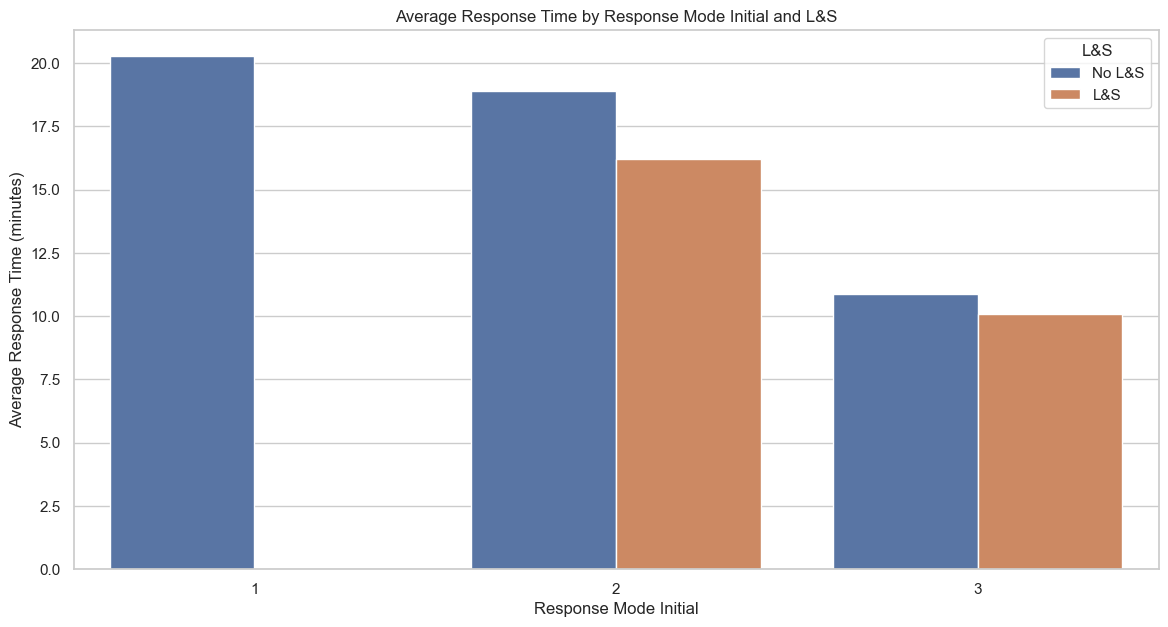

In [49]:
plt.figure(figsize=(14, 7))
sns.barplot(x='Response_Mode_Initial', y='Average_Response_Time', hue='Response_Mode_initial', data=response_mode_desc_stats, errorbar=None)
plt.title('Average Response Time by Response Mode Initial and L&S')
plt.xlabel('Response Mode Initial')
plt.ylabel('Average Response Time (minutes)')
plt.legend(title='L&S')
plt.show()

In [64]:
# Calculate total calls and average response time for each 'Call_Year'
yearly_stats = df.groupby('Call_Year')['Resp_Time'].agg(['count', 'mean']).reset_index()
yearly_stats.columns = ['Call_Year', 'Total_Calls', 'Average_Response_Time']

# Display the table using pandas Styler
styled_table = (yearly_stats.style
                .set_caption('Total Calls and Average Response Time by Call Year')
                .set_table_styles([{
                    'selector': 'caption',
                    'props': 'caption-side: top; font-size: 1.5em; color: White;'
                }])
                .format({
                    'Total_Calls': '{:,.0f}',
                    'Average_Response_Time': '{:.2f}'
                }))

styled_table

,Call_Year,Total_Calls,Average_Response_Time
0,2009,"125,416",15.85
1,2010,"161,521",13.94
2,2011,"186,208",13.53
3,2012,"196,470",13.88
4,2013,"203,307",14.46
5,2014,"210,650",15.28


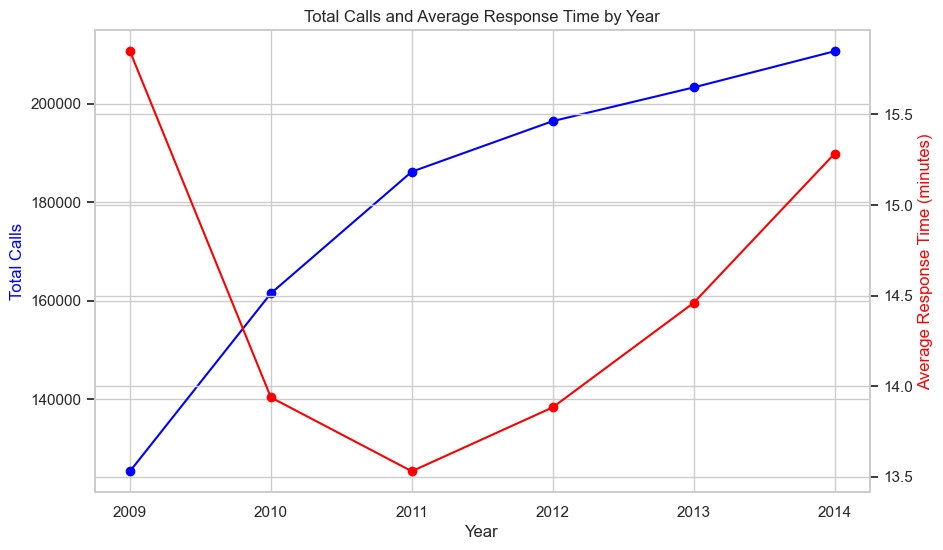

In [68]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plotting the total calls
ax1.plot(yearly_stats['Call_Year'], yearly_stats['Total_Calls'], color='blue', marker='o', label='Total Calls')
ax1.set_xlabel('Year')
ax1.set_ylabel('Total Calls', color='blue')

# Creating a secondary y-axis for average response time
ax2 = ax1.twinx()
ax2.plot(yearly_stats['Call_Year'], yearly_stats['Average_Response_Time'], color='red', marker='o', label='Average Response Time')
ax2.set_ylabel('Average Response Time (minutes)', color='red')

# Adding title and legend
plt.title('Total Calls and Average Response Time by Year')
plt.grid(True)
plt.show()


In [111]:
# Calculate total calls and average response time for each city and year
city_yearly_stats = df.groupby(['Call_Year', 'Call_Loc_Community'])['Resp_Time'].agg(['count', 'mean']).reset_index()
city_yearly_stats.columns = ['Call_Year', 'Call_Loc_Community', 'Total_Calls', 'Average_Response_Time']

# Sort by Call_Year and Average_Response_Time in descending order
city_yearly_stats = city_yearly_stats.sort_values(by=['Call_Year', 'Average_Response_Time'], ascending=[True, False])

# Apply background colors to each year
styled_table = (city_yearly_stats.style
                .background_gradient(cmap='coolwarm', subset=['Average_Response_Time'])
                .set_caption('Total Calls and Average Response Time by City and Year')
                .set_table_styles([{
                    'selector': 'caption',
                    'props': 'caption-side: top; font-size: 1.5em; color: white;'
                }])
                .format({
                    'Total_Calls': '{:,.0f}',
                    'Average_Response_Time': '{:.2f}'
                }))

styled_table

,Call_Year,Call_Loc_Community,Total_Calls,Average_Response_Time
0,2009,Burnaby,"14,542",18.03
2,2009,Kamloops,211,17.87
7,2009,Saanich,207,17.77
4,2009,Langley,"8,818",17.49
6,2009,Richmond,"9,768",16.99
3,2009,Kelowna,305,16.85
8,2009,Surrey,"28,147",16.49
1,2009,Chilliwack,"7,527",15.11
9,2009,Vancouver,"55,352",14.58
5,2009,Nanaimo,254,14.39


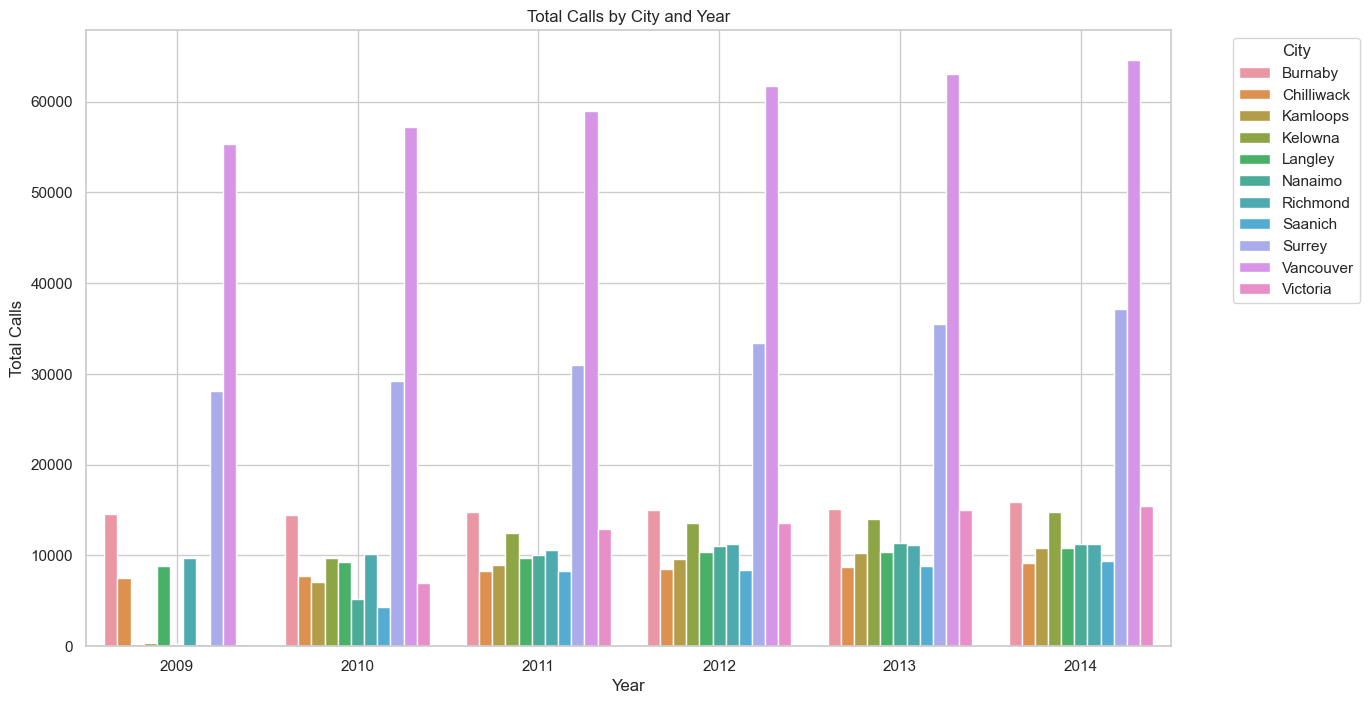

In [83]:
plt.figure(figsize=(14, 8))
sns.barplot(data=city_yearly_stats, x='Call_Year', y='Total_Calls', hue='Call_Loc_Community')
plt.xlabel('Year')
plt.ylabel('Total Calls')
plt.title('Total Calls by City and Year')
plt.legend(title='City', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.grid(True)
plt.show()


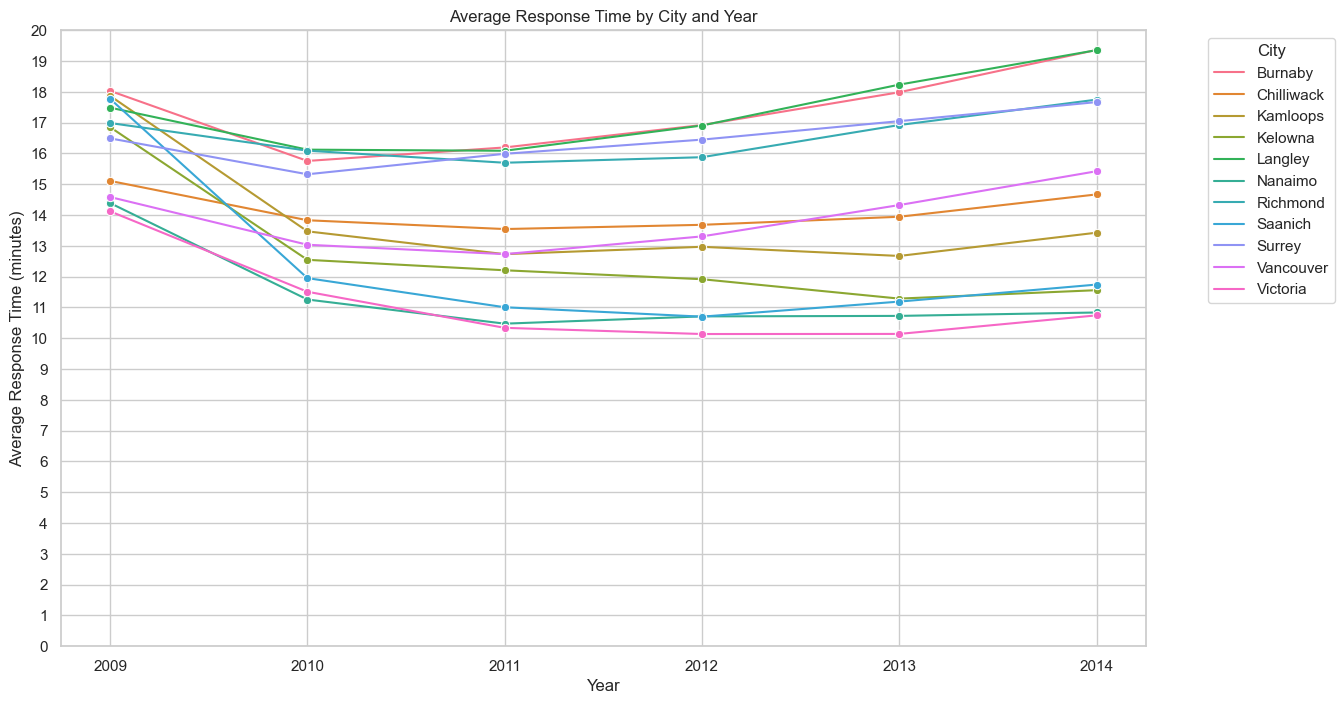

In [75]:
plt.figure(figsize=(14, 8))
sns.lineplot(data=city_yearly_stats, x='Call_Year', y='Average_Response_Time', hue='Call_Loc_Community', marker='o')
plt.xlabel('Year')
plt.ylabel('Average Response Time (minutes)')
plt.title('Average Response Time by City and Year')
plt.legend(title='City', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.yticks(range(0, 21))

plt.grid(True)
plt.show()


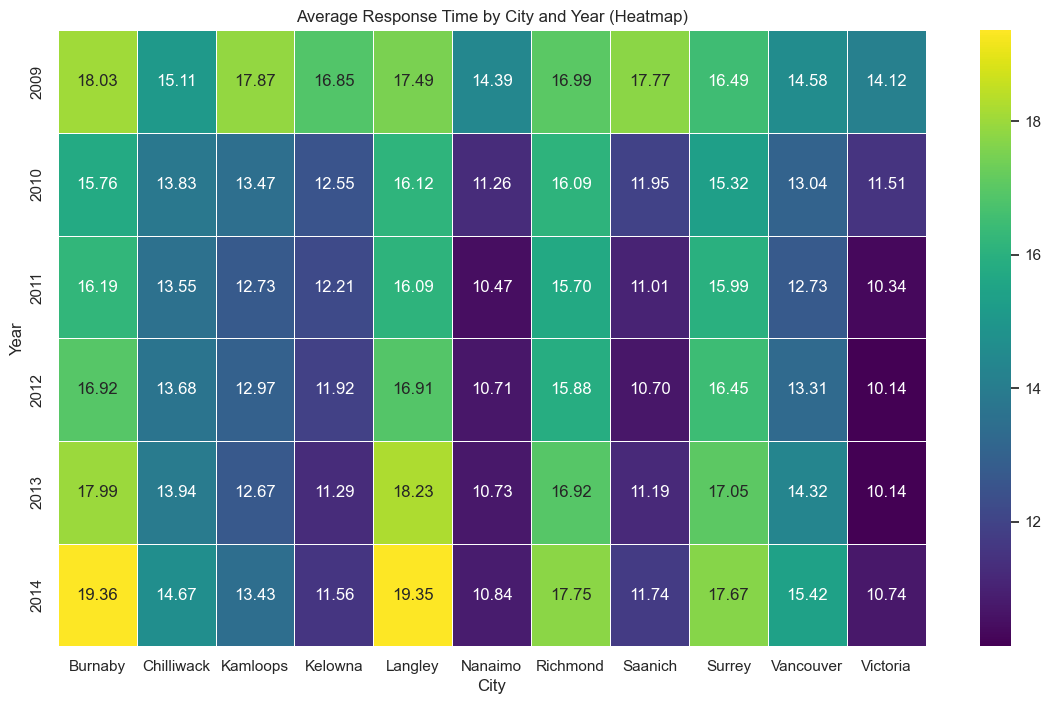

In [74]:
# Pivot the data to prepare for heatmap
heatmap_data = city_yearly_stats.pivot(index='Call_Year', columns='Call_Loc_Community', values='Average_Response_Time')

# Plot the heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(data=heatmap_data, cmap='viridis', annot=True, fmt=".2f", linewidths=0.5)
plt.xlabel('City')
plt.ylabel('Year')
plt.title('Average Response Time by City and Year (Heatmap)')
plt.show()
